# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в   прикассовой зоне поможет определять возраст клиентов, чтобы:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

План выполнения:  
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

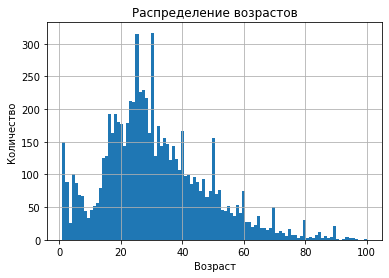

In [4]:
labels.hist(bins=100)
plt.title('Распределение возрастов')
plt.ylabel('Количество')
plt.xlabel('Возраст');

In [5]:
features, target = next(train_gen_flow)

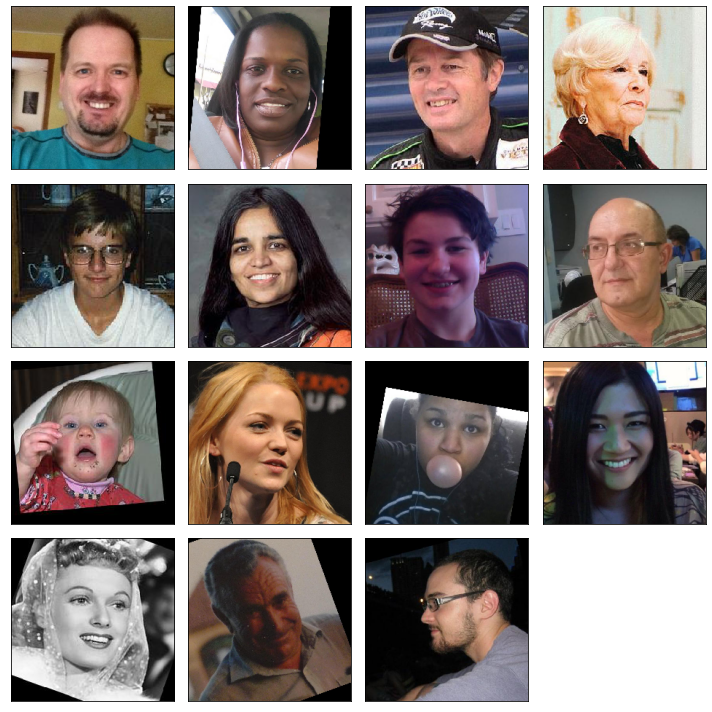

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Самое большое количество данных для фотографий с людьми возраста от 20 до 40 лет. Так же если мы взглянем на фотографии увидим, что на некоторых фото присутствует много лишних объектов, которые могут закрывать лицо, что точно не может модели в обучении.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 50s - loss: 198.9247 - mae: 10.1713 - val_loss: 535.1429 - val_mae: 18.0284
Epoch 2/5
356/356 - 41s - loss: 68.5429 - mae: 6.2942 - val_loss: 188.0788 - val_mae: 10.5279
Epoch 3/5
356/356 - 40s - loss: 38.4191 - mae: 4.7658 - val_loss: 73.4582 - val_mae: 6.5455
Epoch 4/5
356/356 - 40s - loss: 24.9955 - mae: 3.8829 - val_loss: 89.6187 - val_mae: 7.1539
Epoch 5/5
356/356 - 49s - loss: 18.3160 - mae: 3.2748 - val_loss: 71.7358 - val_mae: 6.2864

```


## Анализ обученной модели

Обученная модель ResNet50 за 5 эпох на тестовой выборке показала MAE 6.2864, что является хорошим результатом, ведь значение MAE в статье о датесете 5.4. 
  
Обученная модель:
1. ResNet50 c параметрами:  
    1. функцией активации relu
    2. функцией потерь mse
    3. метрикой MAE
    4. Оптимайзером Adam с LearningRate = 0.0001